In [1]:
#Title: Creating and Cleaning A Pandas Dataframe and Conducting Regression Analysis for Carbon Recovery - Florida Fire Study
#Author: Emily Evenden
#Date: May 22, 2020

'''
The purpose of this script to to use advanced Python packages to create a dataframe from multiple geospatial raster layers.
The dataframe wwas then be used for data visualization and regression analysis. The aim of this analysis is to see how
fire severity impacts net ecosystem productivity recovery and aboveground biomass regrowth following fire disturbances.

The raster layers come from the 'Forest Carbon Stocks and Fluxes After Disturbance, Southeastern USA, 1990-2010' dataset available 
through the Oak Ridge National Laboratory. Specifically, the purpose of this script to create a dataframe from 8 raster layers 
inclduing: Aboveground Biomass (Kg C m-2) at 1990, 2000, and 2010; Net Ecosystem Productivity (g C m-2) at 1990, 2000, and 2010; 
Forest Type; and Year of Fire Disturbance.

The raster layer were preprocessed using TerrSet prior to using them in this script. All layers have a have an AlbersUS83 projection
and have a 30m resolution.
'''

#Import packages
#Numpy is used to make arrays
import numpy as np
#Pandas can used Numpy arrays to create dataframes
import pandas as pd
#PIL is used to open image files to obtain pixel values
from PIL import Image
#OS allows the user to set the working folder
import os
#Seaborn is a library for nice graphical data visualization displays
import seaborn as sns
#MatPlotLib is a library for data visualization
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Set working directory
dir = os.chdir("C:\\Users\\Emily\\Documents\\Summer_2020\\Py_DataScience_and_MachineLearning\\original\\FL_Script\\Python_FL_Project\\Python_FL_Project")

In [3]:
### PART 1: DATA FRAME CREATION & CLEAN UP

#This line deactivates the zip bomb safety in Python 3. Because I am working with large files, I want to deactivate the size limit imposed by the zip bomb check.
Image.MAX_IMAGE_PIXELS = None

#This section opens each TIFF as an array and assigns them to a variable. Because I already preprocessed the spatial data the images are all the same size.
#AGB = Aboveground Biomass
#NEP = Net Ecosystem Productivity
#Forest Type = Numeric Code for Forest Type
#Burn Year = # of Years after 1970 when the area was burned

AGB_2010 = np.asarray(Image.open('Smaller_FL_agb_2010.tif'))
AGB_2000 = np.asarray(Image.open('Smaller_FL_agb_2000.tif'))
AGB_1990 = np.asarray(Image.open('Smaller_FL_agb_1990.tif'))
Forest_Type = np.asarray(Image.open('Smaller_FL_forest_group_NAFD.tif'))
NEP_1990 = np.asarray(Image.open('Smaller_FL_nep_1990.tif'))
NEP_2000 = np.asarray(Image.open('Smaller_FL_nep_2000.tif'))
NEP_2010 = np.asarray(Image.open('Smaller_FL_nep_2010.tif'))
Burn_Year = np.asarray(Image.open('Smaller_FL_years_disturb_MTSB.tif'))

#Check point to make sure it works 
print('Ok')



Ok


In [4]:
#This section flattens each array so the 2D data is converted to 1D data. This allows each raster layer to become a column in the dataframe.

FL_AGB_1990 = AGB_1990.flatten()
FL_AGB_2000 = AGB_2000.flatten()
FL_AGB_2010 = AGB_2010.flatten()
FL_Forest_Type = Forest_Type.flatten()
FL_NEP_1990 = NEP_1990.flatten()
FL_NEP_2000 = NEP_2000.flatten()
FL_NEP_2010 = NEP_2010.flatten()
FL_Burn_Year = Burn_Year.flatten()

#Check point
print('Ok')


Ok


In [5]:
#Here I stack all of the flattened arrays and transpose them into vertical columns. This creates a larger 2D array, FL_arr, from the multiple 1D arrays.
FL_arr = np.vstack([FL_AGB_1990, FL_AGB_2000, FL_AGB_2010, FL_Forest_Type, FL_NEP_1990, FL_NEP_2000, FL_NEP_2010, FL_Burn_Year]).T

In [6]:
#A Pandas dataframe was then created from with the vertically stacked 2D array, FL_arr, and assigned column names.
FL_Data = pd.DataFrame(FL_arr, columns=['AGB_1990', 'AGB_2000','AGB_2010', 'Forest_Type', 'NEP_1990', 'NEP_2000', 'NEP_2010', 'Burn_Year'])

#Check point. This shows the column names and first five entries. 
FL_Data.head()

,AGB_1990,AGB_2000,AGB_2010,Forest_Type,NEP_1990,NEP_2000,NEP_2010,Burn_Year
0,3082,4995,1521,160,158,188,157,0
1,2684,4660,1331,160,154,182,134,0
2,2294,4406,1331,160,152,178,134,0
3,3016,4981,1324,160,158,185,164,0
4,3016,4981,1324,160,158,185,164,0


In [7]:
'''
Now that the dataframe is created, I want to remove rows that are not necessary for the analysis.
First, I want to remove pixels which did not experience fire, or had fires which occured before or at 1990 and at 2010.
I don't have carbon data outsides of 1990-2010, so I can analyze fire outside of that time interval.
This will leave only pixels which burned between 1991 - 2009.
'''

#First, I identified all unique values for Burn_Year to see whether there are pixels that occured outside of my target time interval.
FL_Data['Burn_Year'].unique()

#The only years outside of my target time interval are 0 (No fire), 16 (1986), 20 (1990), and 40 (2010).
FL_Data = FL_Data[(FL_Data.Burn_Year != 0) & (FL_Data.Burn_Year != 16) & (FL_Data.Burn_Year != 20) & (FL_Data.Burn_Year != 40)]

#Check that pixels with unwanted years were removed
FL_Data['Burn_Year'].unique()

array([39, 23, 27, 22, 36, 21, 28, 35, 38, 25, 31, 30, 29, 26, 24, 34, 37])

In [8]:
'''
Now I want to limit the dataframe to pixels that deifnitely had less aboveground following a fire event. 
Though this is not necessarily scientifically sound decision, my professor and I realized there may be a lot of 
edge pixels which are considered burned but don't follow expected trends when looking at the AGB and NEP layers.
'''

#Here, I create two columns to find the difference in AGB between 1990 & 2000 and 2000 & 2010.
FL_Data['Minus_90_00'] = FL_Data['AGB_1990'] - FL_Data['AGB_2000']
FL_Data['Minus_00_10'] = FL_Data['AGB_2000'] - FL_Data['AGB_2010']

#I only select pixels here the net change in AGB between 1990 - 2000 or 2000 - 2010 is positive. (This means there's less AGB in the second time point).
FL_Data = FL_Data[(FL_Data.Minus_90_00 > 0) | (FL_Data.Minus_00_10 > 0)]

#Here, I created two more columns to show the date of the fire and it's age at 2010.
FL_Data['Date'] = 1970 + FL_Data['Burn_Year'] 
FL_Data['Burn_Scar_Age'] = 40 - FL_Data['Burn_Year']

#Check
print (FL_Data)

         AGB_1990  AGB_2000  AGB_2010  Forest_Type  NEP_1990  NEP_2000  \
2421         3111      4180      1833          140       114       123   
2422         4320      5064      1897          140       120       109   
2423         3826      4693      1897          140       121       117   
2424         4260      1091      2049          140       121     -1105   
2428         3985      4820      1897          140       121       115   
...           ...       ...       ...          ...       ...       ...   
8445212      3565      4555      1128          140       120       118   
8445216      4280      5062      1128          140       118       107   
8445222      4092      4920      1741          140       121       113   
8445223      4649      1073      2195          140       116      -410   
8445230      3428      4465      1128          140       120       120   

         NEP_2010  Burn_Year  Minus_90_00  Minus_00_10  Date  Burn_Scar_Age  
2421           80         39     

In [9]:
#I want to create categorize the pixel as having a burn severity of High, Medium, and Low. 
#I decided the assign these labels based on the percent of aboveground biomass lost by a pixel following a fire.

#First, I created a new column calculating the percent aboveground biomass lost. For pixel burned before 2001, I calculated this using AGB_1990 and AGB_2000.
FL_Data['Burn_Severity'] = ((FL_Data['AGB_1990']-FL_Data['AGB_2000'])/FL_Data['AGB_1990']*100)

#However, for pixels burned from 2001 - 2009, I want to calculate the percent of AGB lost using the AGB 2000 and AGB 2010 columns. In this case, I replaced the values in 'Burn_Severity' for select rows based on their date.
FL_Data.loc[(FL_Data.Date>2000), 'Burn_Severity'] = ((FL_Data['AGB_2000']-FL_Data['AGB_2010'])/FL_Data['AGB_2000']*100)

#Check point
print (FL_Data)

         AGB_1990  AGB_2000  AGB_2010  Forest_Type  NEP_1990  NEP_2000  \
2421         3111      4180      1833          140       114       123   
2422         4320      5064      1897          140       120       109   
2423         3826      4693      1897          140       121       117   
2424         4260      1091      2049          140       121     -1105   
2428         3985      4820      1897          140       121       115   
...           ...       ...       ...          ...       ...       ...   
8445212      3565      4555      1128          140       120       118   
8445216      4280      5062      1128          140       118       107   
8445222      4092      4920      1741          140       121       113   
8445223      4649      1073      2195          140       116      -410   
8445230      3428      4465      1128          140       120       120   

         NEP_2010  Burn_Year  Minus_90_00  Minus_00_10  Date  Burn_Scar_Age  \
2421           80         39    

In [10]:
#After creating a numeric variable to measure burn severity, I want to place pixels into categorical bins.
#First I create list of categorical bins
bs_labels = ['Low', 'Moderate', 'Severe']

#Then I assign custom bounds for the intervals.
cut_bins = [0, 30, 70, 100]

#I used the pd.cut function to create a new variable which places each pixel into a categorical bin based on it 'Burn_Severity' value.
FL_Data['Severity_Label'] = pd.cut(FL_Data['Burn_Severity'], bins=cut_bins, labels=bs_labels)

#Check point
print (FL_Data)

         AGB_1990  AGB_2000  AGB_2010  Forest_Type  NEP_1990  NEP_2000  \
2421         3111      4180      1833          140       114       123   
2422         4320      5064      1897          140       120       109   
2423         3826      4693      1897          140       121       117   
2424         4260      1091      2049          140       121     -1105   
2428         3985      4820      1897          140       121       115   
...           ...       ...       ...          ...       ...       ...   
8445212      3565      4555      1128          140       120       118   
8445216      4280      5062      1128          140       118       107   
8445222      4092      4920      1741          140       121       113   
8445223      4649      1073      2195          140       116      -410   
8445230      3428      4465      1128          140       120       120   

         NEP_2010  Burn_Year  Minus_90_00  Minus_00_10  Date  Burn_Scar_Age  \
2421           80         39    

In [11]:
#Additionally, I want to replace the numeric codes signifying 'Forest_Type' with descriptive str labels because it's more intuitive to read.
#First I create a list of the str forest type names
forest_type_list = ['White/Red/Jack Pine', 'Spruce/Fir', 'Longleaf/Slash Pine', 'Loblolly/Shortleaf Pine', 'Pinyon/Juniper', 'Oak/Pine', 'Oak/Hickory', 'Oak/Gum/Cypress', 'Elm/Ash/Cottonwood', 'Maple/Beech/Birch', 'Tropical Hardwoods', 'Exotic Hardwoods']

#Then, I create a list of the values associated with each name
code_list = [100, 120, 140, 160, 180, 400, 500, 600, 700, 800, 980, 990]

#Finally, I create a dictionary which associates each value with a str label.
forest_dict = dict(zip(code_list, forest_type_list))

# To replace the numeric code Forest Type with the str label, I used the .replace function.
FL_Data['Forest_Type'].replace(forest_dict, inplace=True)



In [12]:
#Here, I drop any rows which have null values. 
FL_Data.dropna(axis=0, how='any')       

,AGB_1990,AGB_2000,AGB_2010,Forest_Type,NEP_1990,NEP_2000,NEP_2010,Burn_Year,Minus_90_00,Minus_00_10,Date,Burn_Scar_Age,Burn_Severity,Severity_Label
2421,3111,4180,1833,Longleaf/Slash Pine,114,123,80,39,-1069,2347,2009,1,56.148325,Moderate
2422,4320,5064,1897,Longleaf/Slash Pine,120,109,43,39,-744,3167,2009,1,62.539494,Moderate
2423,3826,4693,1897,Longleaf/Slash Pine,121,117,43,39,-867,2796,2009,1,59.578095,Moderate
2428,3985,4820,1897,Longleaf/Slash Pine,121,115,43,39,-835,2923,2009,1,60.643154,Moderate
2441,2125,3465,1577,Longleaf/Slash Pine,89,119,156,39,-1340,1888,2009,1,54.487734,Moderate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8445211,3913,4775,1741,Longleaf/Slash Pine,121,116,41,39,-862,3034,2009,1,63.539267,Moderate
8445212,3565,4555,1128,Longleaf/Slash Pine,120,118,13,39,-990,3427,2009,1,75.236004,Severe
8445216,4280,5062,1128,Longleaf/Slash Pine,118,107,13,39,-782,3934,2009,1,77.716318,Severe
8445222,4092,4920,1741,Longleaf/Slash Pine,121,113,41,39,-828,3179,2009,1,64.613821,Moderate


In [14]:
'''
Finally, I wanted to limit my dataframe to the most common forest type in my study area. Prior to this, I examined the 
index count for each forest type. Longleaf/Slash Pine forests had the most pixels. In addition, I decided to get rid of 
pixels with a "Low" severity label because there were much fewer pixels with that label.
'''
#Here, I isolate the observations NOT considered Longleaf/Slash Pine forest
indexNames = FL_Data[ (FL_Data['Forest_Type'] != 'Longleaf/Slash Pine')].index

#In addition, I isolated the observaions with a Low Burn Severity
indexNames2 = FL_Data[(FL_Data['Severity_Label'] == 'Low')].index

#Finally, I dropped rows which did not meet my criteria
FL_Data.drop(indexNames2, inplace=True)
FL_Data.drop(indexNames, inplace=True)


In [15]:
#Even through "Low Severity" now longer contains any observations, it still appears as a category in graphs. 
#Therefore, I had to drop the "unused" category
FL_Data.Severity_Label = FL_Data.Severity_Label.cat.remove_unused_categories()

#Here I checked the count for each category - "Low Severity" doesn't appear
FL_Data["Severity_Label"].value_counts()

Severe      108721
Moderate     80499
Name: Severity_Label, dtype: int64

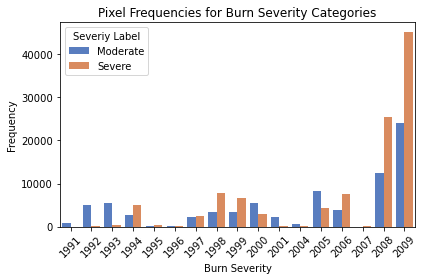

In [17]:
### PART 2: DATA VISUALIZATION WITH SEABORN

#Histogram of Moderate and Sevever Burns
hist = sns.countplot(x = 'Date', palette='muted', data= FL_Data, hue = 'Severity_Label')
#Set axis and title labels
hist.set_xlabel('Burn Severity')
#I rotated the x-axis labels because they were overlapping each other
plt.xticks(rotation=45)
hist.set_ylabel('Frequency')
hist.set_title('Pixel Frequencies for Burn Severity Categories')
plt.tight_layout()

#Here, I customize the legend
#First, I set the legend to a variable
leg = hist.get_legend()
#Then, I set a new axis title
new_title = 'Severiy Label'
#Finally, I reset the legend labels to get rid of the column title
leg.set_title(new_title)
new_labels = ['Moderate', 'Severe']
#This sets the new legend
for t, l in zip(leg.texts, new_labels): t.set_text(l)

#Output this image are a PNG file
plt.savefig("Histogram_Severity.png")

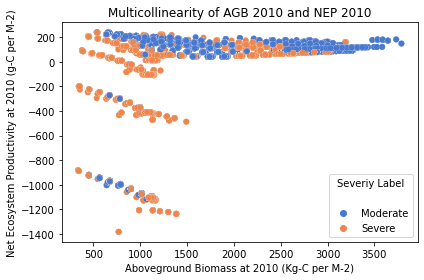

In [23]:
#Create a scatterplot of Aboveground Biomass and Net Ecosystem Productivity to examine multicollinearity
#Create a list of hue rankings
hue_ranking = ['Moderate', 'Severe']

#Here, I create a the scatterplot which plots both Moderate and Severe data points
fig = sns.scatterplot(x="AGB_2010", y="NEP_2010",
                hue="Severity_Label",
                palette="muted",
                hue_order=hue_ranking,
                linewidth=.1,
                data=FL_Data)

#Set title and axes labels. 
plt.title("Multicollinearity of AGB 2010 and NEP 2010")
plt.xlabel("Aboveground Biomass at 2010 (Kg-C per M-2)")
plt.ylabel("Net Ecosystem Productivity at 2010 (g-C per M-2)")

#Here, I customize the legend
#First, I set the legend to a variable
leg = fig.get_legend()
#Then, I set a new axis title
new_title = 'Severiy Label'
#Finally, I reset the legend labels to get rid of the column title
leg.set_title(new_title)
new_labels = ['','Moderate', 'Severe']
#This sets the new legend
for t, l in zip(leg.texts, new_labels): t.set_text(l)

#Here, I ensure none of labels overlap
plt.tight_layout()

#Output this image are a PNG file
plt.savefig("Scatterplot_AGB_NEP.png")

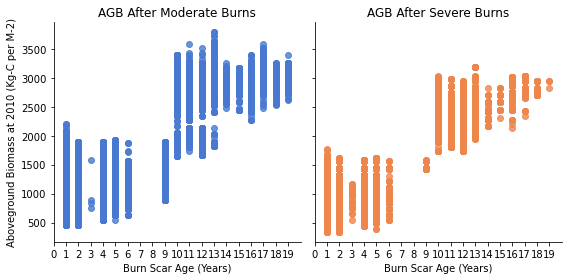

In [147]:
#Create a FacetGrid plot to compare how Aboveground Biomass recovers as a Burn Scar ages
lm = sns.lmplot(x="Burn_Scar_Age", y="AGB_2010", col="Severity_Label", hue="Severity_Label", data=FL_Data,
           col_wrap=2, ci=None, palette="muted", height=4,
           scatter=True, fit_reg=False)

#This section allows me to customs the subplots
fig = lm.fig

#Assign each subplot axes to a variables
a1 = fig.axes[1]
a0 = fig.axes[0]

#Set the range and labeling of the x-axis
a0.set_xlim(0,20)
a0.set_xticks(range(0,20))

#Set title and axis labels
a0.set_title("AGB After Moderate Burns")
a0.set(xlabel= "Burn Scar Age (Years)", ylabel="Aboveground Biomass at 2010 (Kg-C per M-2)")
a1.set_title("AGB After Severe Burns")
a1.set(xlabel= "Burn Scar Age (Years)")

#Stop overlapping of subplots
fig.tight_layout()

#Output this image are a PNG file
plt.savefig("FacetGrid_AGB_Raw.png")

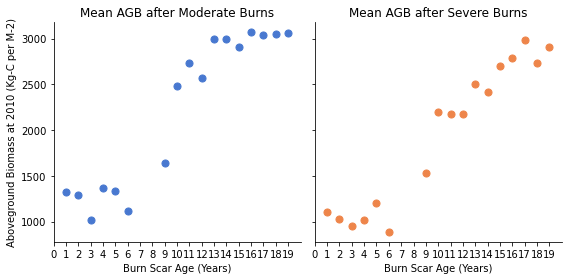

In [148]:
#Here, I create another FacetPlot both instead its for the mean values of Aboveground Biomass. 
#This allows us to more clearly see how the correlation between the two datasets differs - since there are many observations

lm = sns.lmplot(x="Burn_Scar_Age", y="AGB_2010", col="Severity_Label", hue="Severity_Label", data=FL_Data, x_estimator=np.mean, 
           col_wrap=2, ci=None, palette="muted", height=4,
           scatter=True, fit_reg=False)

#Assign each subplot axes to a variables
fig = lm.fig
a1 = fig.axes[1]
a0 = fig.axes[0]

#Set the range and labeling of the x-axis
a0.set_xlim(0,20)
a0.set_xticks(range(0,20))

a0.set_title("Mean AGB after Moderate Burns")
a0.set(xlabel= "Burn Scar Age (Years)", ylabel="Aboveground Biomass at 2010 (Kg-C per M-2)")

a1.set_title("Mean AGB after Severe Burns")
a1.set(xlabel= "Burn Scar Age (Years)")

#Stop overlapping of subplots
fig.tight_layout()

#Output this image are a PNG file
plt.savefig("FacetGrid_AGB_Mean.png")

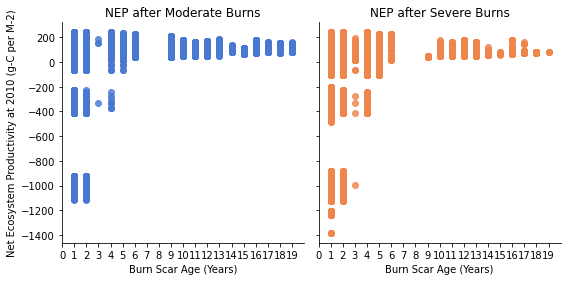

In [149]:
#Create a FacetGrid plot to compare how Net Ecosystem Productivity recovers as a Burn Scar ages
lm2 = sns.lmplot(x="Burn_Scar_Age", y="NEP_2010", col="Severity_Label", hue="Severity_Label", data=FL_Data,
           col_wrap=2, ci=None, palette="muted", height=4,
           scatter=True, fit_reg=False)

#Again, I assign the subplots, set the axes and titles.
fig2 = lm2.fig
a2 = fig2.axes[0]
a3 = fig2.axes[1]

a2.set_xlim(0,20)
a2.set_xticks(range(0,20))

a2.set_title("NEP after Moderate Burns")
a2.set(xlabel= "Burn Scar Age (Years)", ylabel="Net Ecosystem Productivity at 2010 (g-C per M-2)")

a3.set_title("NEP after Severe Burns")
a3.set(xlabel= "Burn Scar Age (Years)")

#Make a tight layout
fig.tight_layout()

#Export the plot
plt.savefig("FacetGrid_NEP_Raw.png")

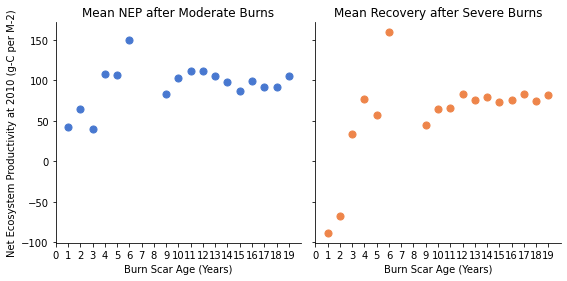

In [150]:
#Finally, make a plot for mean NEP so we can see the trends more clearly
lm2 = sns.lmplot(x="Burn_Scar_Age", y="NEP_2010", col="Severity_Label", hue="Severity_Label", data=FL_Data, x_estimator= np.mean, 
           col_wrap=2, ci=None, palette="muted", height=4,
           scatter=True, fit_reg=False)

#Customize each plot, like above
fig2 = lm2.fig
a2 = fig2.axes[0]
a3 = fig2.axes[1]

a2.set_xlim(0,20)
a2.set_xticks(range(0,20))

a2.set_title("Mean NEP after Moderate Burns")
a2.set(xlabel= "Burn Scar Age (Years)", ylabel="Net Ecosystem Productivity at 2010 (g-C per M-2)")

a3.set_title("Mean Recovery after Severe Burns")
a3.set(xlabel= "Burn Scar Age (Years)")

#Create tight layout
fig.tight_layout()

#Save figure
plt.savefig("FacetGrid_NEP_Mean.png")

In [151]:
#Create separate dataframes for Moderate and Severe burns in order to run two separate Regression Analysis
#Create dataframe for moderate burns
Mod_FL = FL_Data[(FL_Data['Severity_Label'] == 'Moderate')]
#Create dataframe for severe burns
Sev_FL = FL_Data[(FL_Data['Severity_Label'] == 'Severe')]
print ("Ok")

Ok


In [152]:
#I created a function to run a Linear Regression. This allows me to call the same 

def LinReg(x,y):
    #Split test data
    from  sklearn.model_selection import train_test_split
    x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.4)
    
    #Reshape Series into 2D Arrays
    x_train = np.array(x_train).reshape(len(x_train),1)
    y_train = np.array(y_train).reshape(len(y_train),1)
    x_test = np.array(x_test).reshape(len(x_test),1)
    y_test = np.array(y_test).reshape(len(y_test),1)
    
    #Initialize Linear Regression Model
    from sklearn.linear_model import LinearRegression
    #Train model using training data
    reg = LinearRegression().fit(x_train, y_train)
    predictions = reg.predict(x_train)
    
    #Un-Nest Values
    intercept = reg.intercept_[0]
    intercept = str(round(intercept, 1))
    x_coef = reg.coef_[0][0]
    x_coef = str(round(x_coef, 1))
    
    #Print intercept and regression coefficients
    print ("The intercept is: %s" % intercept)
    print ("The x-coefficient is: %s " % x_coef)
    
    #Prediction testing data
    predictions = reg.predict(x_test)
    
    #Print RMSE and R-squared Error
    from sklearn.metrics import mean_squared_error, r2_score
    
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    rmse = str(round(rmse, 2))
    r2 = r2_score(y_test, predictions)
    r2 = str(round(r2, 2))

    print("The RMSE is %s and the R-Squared is: %s " % (rmse,r2))
    
    #Create a scatterplot of predictions and expected values
    fig1 = plt.figure()
    fig1 = plt.scatter(y_test, predictions)
    plt.title("Scatterplot of True and Predicted Y-Values")
    plt.xlabel("True Y-Values")
    plt.ylabel("Predicted Y-Values")
    
    #Create a histogram of residuals by subtracting the observed values from expected. 
    #In this case, not normally distributed so linear regression in probably not the best choice.
    fig2 = plt.figure()
    fig2 = sns.distplot((y_test-predictions), kde=False)
    plt.title("Residuals of True and Predicted Y-Values")
    plt.xlabel("Residual Value")
    plt.ylabel("Frequency")

The intercept is: 1097.9
The x-coefficient is: 116.1 
The RMSE is 425.33 and the R-Squared is: 0.74 


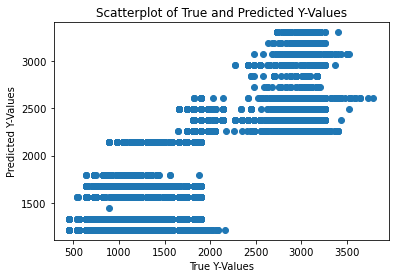

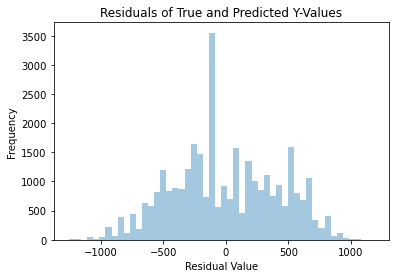

In [117]:
#Run Regression for Burn Scar Age and Moderate Fire Abovegorund Biomass
LinReg(Mod_FL['Burn_Scar_Age'], Mod_FL['AGB_2010'])

The intercept is: 886.1
The x-coefficient is: 113.0 
The RMSE is 255.43 and the R-Squared is: 0.82 


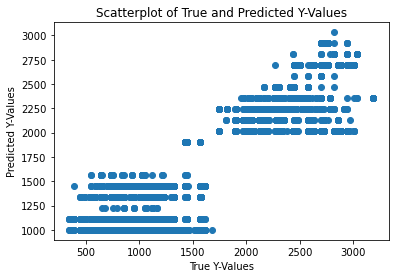

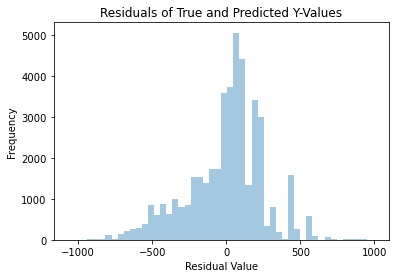

In [53]:
#Run Regression for Burn Scar Age and Severe Fire Aboveground Biomass
LinReg(Sev_FL['Burn_Scar_Age'], Sev_FL['AGB_2010'])

The intercept is: 59.1
The x-coefficient is: 3.0 
The RMSE is 167.93 and the R-Squared is: 0.01 


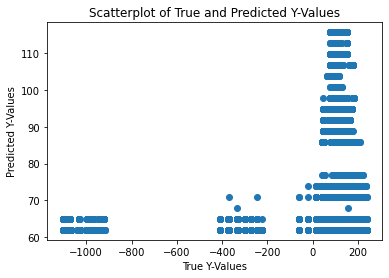

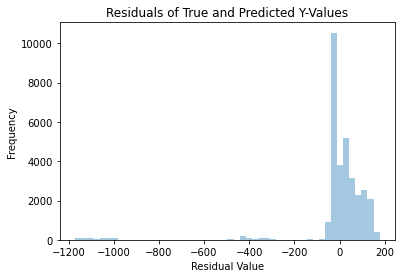

In [54]:
#Run Regression for Burn Scar Age and Moderate Fire Net Ecosystem Productivity
LinReg(Mod_FL['Burn_Scar_Age'], Mod_FL['NEP_2010'])

The intercept is: -85.7
The x-coefficient is: 13.3 
The RMSE is 216.2 and the R-Squared is: 0.08 


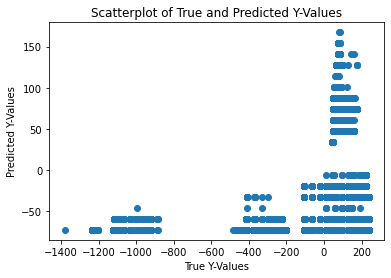

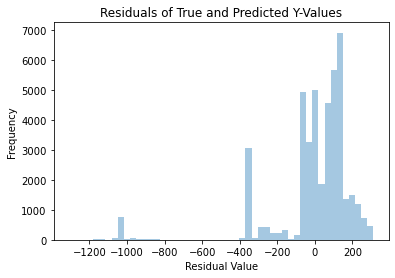

In [55]:
#Run Regression for Burn Scar Age and Severe Fire Net Ecosystem Productivity
LinReg(Sev_FL['Burn_Scar_Age'], Sev_FL['NEP_2010'])

In [140]:
def QuadReg(x,y):
    from  sklearn.model_selection import train_test_split
    x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.4)
      
    from sklearn.preprocessing import PolynomialFeatures
    
    #Transform data to include another axis
    x_train = x_train[:, np.newaxis]
    y_train = y_train[:, np.newaxis]
    x_test = x_test[:, np.newaxis]
    y_test = y_test[:, np.newaxis]
    
    x_train = np.array(x_train).reshape(len(x_train),1)
    y_train = np.array(y_train).reshape(len(y_train),1)
    x_test = np.array(x_test).reshape(len(x_test),1)
    y_test = np.array(y_test).reshape(len(y_test),1)
    

    #Set the Polynomial power. It's quadratic here
    polynomial_features= PolynomialFeatures(degree=2)
    x_poly = polynomial_features.fit_transform(x_train)
    x_test_poly = polynomial_features.fit_transform(x_test)
    
    from sklearn.linear_model import LinearRegression
    
    #Run Regression with transformed independent variables
    model = LinearRegression().fit(x_poly, y_train)
    y_poly_pred = model.predict(x_test_poly)
    
    #Un-Nest Values
    intercept = model.intercept_[0]
    intercept = str(round(intercept, 1))
    x_coef1 = model.coef_[0][0]
    x_coef1 = str(round(x_coef1, 2))
    x_coef2 = model.coef_[0][1]
    x_coef2 = str(round(x_coef2, 2))
    x_coef3 = model.coef_[0][2]
    x_coef3 = str(round(x_coef3, 2))
    
    #Print intercept and regression coefficients
    print ("The intercept is: %s" % intercept)
    print ("The X coefficent is %s and the X^2 coefficent is %s" %(x_coef2, x_coef3))
    
    from sklearn.metrics import mean_squared_error, r2_score
    rmse = np.sqrt(mean_squared_error(y_test, y_poly_pred))
    rmse = str(round(rmse, 2))
    r2 = r2_score(y_test, y_poly_pred)
    r2 = str(round(r2, 2))
    print("The RMSE is %s and the R-Squared is: %s " % (rmse,r2))
    
    #Create a scatterplot of predictions and expected values
    fig3 = plt.figure()
    fig3 = plt.scatter(y_test, y_poly_pred)
    plt.title("Scatterplot of True and Predicted Y-Values")
    plt.xlabel("True Y-Values")
    plt.ylabel("Predicted Y-Values")
    
    #Create a histogram of residuals by subtracting the observed values from expected. 
    #In this case, not normally distributed so linear regression in probably not the best choice.
    fig4 = plt.figure()
    fig4 = sns.distplot((y_test-y_poly_pred), kde=False)
    plt.title("Residuals of True and Predicted Y-Values")
    plt.xlabel("Residual Value")
    plt.ylabel("Frequency")

The intercept is: 1123.9
The X coefficent is 102.0 and the X^2 coefficent is 0.8
The RMSE is 425.07 and the R-Squared is: 0.74 


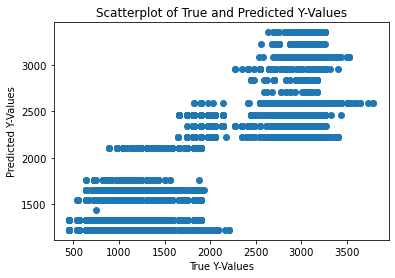

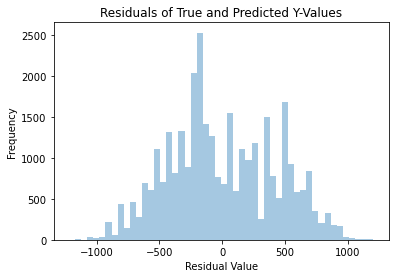

In [141]:
QuadReg(Mod_FL['Burn_Scar_Age'], Mod_FL['AGB_2010'])

The intercept is: 1000.7
The X coefficent is 37.32 and the X^2 coefficent is 5.1
The RMSE is 243.31 and the R-Squared is: 0.84 


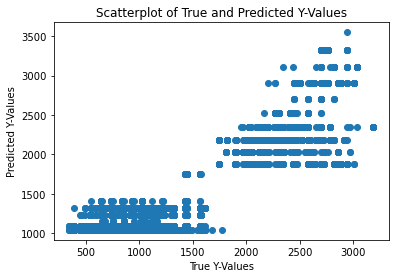

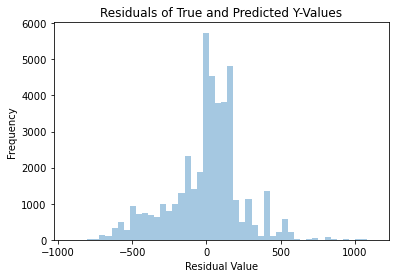

In [142]:
QuadReg(Sev_FL['Burn_Scar_Age'], Sev_FL['AGB_2010'])

The intercept is: 34.8
The X coefficent is 14.48 and the X^2 coefficent is -0.65
The RMSE is 163.59 and the R-Squared is: 0.02 


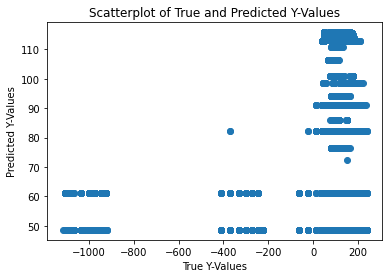

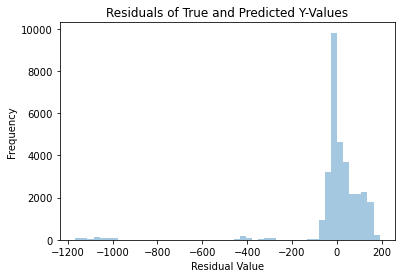

In [143]:
QuadReg(Mod_FL['Burn_Scar_Age'], Mod_FL['NEP_2010'])

The intercept is: -124.2
The X coefficent is 39.69 and the X^2 coefficent is -1.79
The RMSE is 218.07 and the R-Squared is: 0.09 


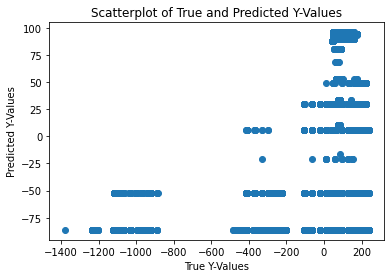

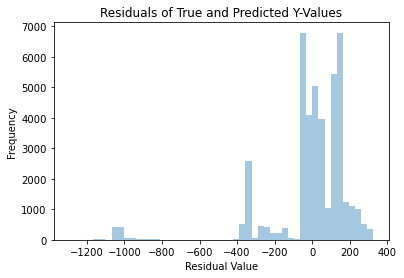

In [144]:
QuadReg(Sev_FL['Burn_Scar_Age'], Sev_FL['NEP_2010'])

In [145]:
#Run Fstat to see if the NEP Data is sifnficantly different from intercept model

#Import F-regression
from sklearn.feature_selection import f_regression

#Create function for F-test
def F_stat(x,y):
    #Reshape arrays
    x_shape = np.array(x).reshape(len(x),1)
    y_shape = np.array(y).reshape(len(y),1)
    
    #Get F-scroes and P-values
    raw_scores, p_values = f_regression(x_shape, y_shape)
    F = raw_scores[0]
    F = str(round(F, 2))
    p = p_values[0]
    p = str(round(p, 2))
    print ("The F-score is: %s" %F)
    print ("The p-value is: %s" %p)
    

In [146]:
F_stat(Mod_FL['Burn_Scar_Age'], Mod_FL['NEP_2010'])

The F-score is: 1013.2
The p-value is: 0.0


c:\users\emily\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [127]:
F_stat(Sev_FL['Burn_Scar_Age'], Sev_FL['NEP_2010'])

The F-score is: 9456.15
The p-value is: 0.0


c:\users\emily\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
